# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


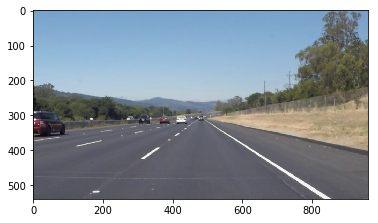

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    print("hough_lines: %d" % len(lines))
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [69]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import math
def hough_lines_lane(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    color=[255, 0, 0]
    thickness=10
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
#     print("hough_lines: %d" % len(lines))
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    left_line_segment = []
    right_line_segment = []
    left_points = []
    right_points = []
    left_slope = []
    right_slope = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = math.atan((y2-y1)/((x2-x1)+0.00000001))
            if (x1+x2)/2<img.shape[1]/2 and slope<0:
                left_line_segment.append((x1,y1,x2,y2))
                left_slope.append(slope)
            elif (x1+x2)/2>img.shape[1]/2 and slope>0:
                right_line_segment.append((x1,y1,x2,y2))  
                right_slope.append(slope)
#     print("left seg slope right seg slope: ", len(left_line_segment), len(left_slope), len(right_line_segment),len(right_slope))

    # use left right slope mean to filter some wrong segment， not use anymore
    left_mean = 0.0
    left_line_segment_filter = []
    for i in range(len(left_slope)):
        left_mean += left_slope[i]
    left_mean /= len(left_slope) 
    for i in range(len(left_slope)):
        if left_slope[i]-left_mean<math.pi/180*10:
            left_line_segment_filter.append(left_line_segment[i])
            
    right_mean = 0.0
    right_line_segment_filter = []
    for i in range(len(right_slope)):
        right_mean += right_slope[i]
    right_mean /= len(right_slope) 
    for i in range(len(right_slope)):
        if right_slope[i]-right_mean<math.pi/180*10:
            right_line_segment_filter.append(right_line_segment[i])
            

    for point in left_line_segment_filter:
        start = [point[0], point[1]]
        stop = [point[2], point[3]]
        length = int(math.sqrt(pow(start[0]-stop[0], 2)+pow(start[1]-stop[1], 2))/5)
#         print(length, end=" | ")
        x_step = (stop[0]-start[0])*1.0/length
        y_step = (stop[1]-start[1])*1.0/length
        for j in range(length):
            left_points.append((int(start[0]+j*x_step), int(start[1]+j*y_step)))
#     print('\n')        
    for point in right_line_segment_filter:
        start = [point[0], point[1]]
        stop = [point[2], point[3]]
        length = int(math.sqrt(pow(start[0]-stop[0], 2)+pow(start[1]-stop[1], 2))/5)
#         print(length, end=" | ")
        x_step = (stop[0]-start[0])*1.0/length
        y_step = (stop[1]-start[1])*1.0/length
        for j in range(length):
            right_points.append((int(start[0]+j*x_step), int(start[1]+j*y_step)))      
            
    # connect center points of left and right segment, not used anymore
#     for i in range(1, len(left_line_segment)):
#         last_seg = left_line_segment[i-1]
#         last_point = (int((last_seg[0]+last_seg[2])/2), int((last_seg[1]+last_seg[3])/2))                
#         now_seg = left_line_segment[i]
#         now_point = (int((now_seg[0]+now_seg[2])/2), int((now_seg[1]+now_seg[3])/2))
#         cv2.line(line_img, last_point, now_point, color, thickness)
#     for i in range(1, len(right_line_segment)):
#         last_seg = right_line_segment[i-1]
#         last_point = (int((last_seg[0]+last_seg[2])/2), int((last_seg[1]+last_seg[3])/2))                
#         now_seg = right_line_segment[i]
#         now_point = (int((now_seg[0]+now_seg[2])/2), int((now_seg[1]+now_seg[3])/2))
#         cv2.line(line_img, last_point, now_point, color, thickness) 
        
#     for i in range(len(left_line_segment_filter)):
#         now_seg = left_line_segment_filter[i]
#         now_point = (int((now_seg[0]+now_seg[2])/2), int((now_seg[1]+now_seg[3])/2))
#         left_points.append((now_seg[0], now_seg[1]))
#         left_points.append(now_point)
#         left_points.append((now_seg[2], now_seg[3]))
        
#     for i in range(len(right_line_segment_filter)):
#         now_seg = right_line_segment_filter[i]
#         now_point = (int((now_seg[0]+now_seg[2])/2), int((now_seg[1]+now_seg[3])/2))
#         right_points.append((now_seg[0], now_seg[1]))
#         right_points.append(now_point)
#         right_points.append((now_seg[2], now_seg[3]))
        
    # just for check every point is right    
#     for i in range(1, len(left_points)):
#         last_point = left_points[i-1]
#         now_point = left_points[i]
# #         print(last_point, now_point, end='||')
#         cv2.line(line_img, last_point, now_point, color, thickness)
#     print('\n')    
#     for i in range(1, len(right_points)):
#         last_point = right_points[i-1]
#         now_point = right_points[i]
# #         print(last_point, now_point, end='||')
#         cv2.line(line_img, last_point, now_point, color, thickness)    
        
    print("points len: ", len(left_points), len(right_points))
    left_points = np.array(left_points)
    right_points = np.array(right_points)
    left_param = cv2.fitLine(left_points, cv2.DIST_L2,0,0.01,0.01)
    right_param = cv2.fitLine(right_points, cv2.DIST_L2,0,0.01,0.01)
#     print("left param: ", left_param)
#     print("right param: ", right_param)
    left_A = -left_param[1]
    left_B = left_param[0]
    left_C = -left_param[0]*left_param[3]+left_param[1]*left_param[2]
    right_A = -right_param[1]
    right_B = right_param[0]
    right_C = -right_param[0]*right_param[3]+right_param[1]*right_param[2]
#     print("left A B C: ", left_A, left_B, left_C)
#     print("rignt A B C: ", right_A, right_B, right_C)
    mask = np.zeros_like(img)
    left_points_fit = []
    right_points_fit = []
    for i in range(img.shape[1]):
        left_x = right_x = i 
        left_y = int(-(left_A*left_x+left_C)/(left_B+0.00000001))
        right_y = int(-(right_A*right_x+right_C)/(right_B+0.00000001))
        if abs(left_y)<img.shape[0]:
            left_points_fit.append((left_x, left_y))
        if abs(right_y)<img.shape[0]:
            right_points_fit.append((right_x, right_y))
    for i in range(1, len(left_points_fit)):
        last_point = left_points_fit[i-1]
        now_point = left_points_fit[i]
        cv2.line(line_img, last_point, now_point, color, thickness)
    for i in range(1, len(right_points_fit)):
        last_point = right_points_fit[i-1]
        now_point = right_points_fit[i]  
#         print(last_point, now_point, end='||')
        cv2.line(line_img, last_point, now_point, color, thickness)
    return line_img

def lane_line_pipeline(image):
    # to gray
#     print('This image is:', type(image), 'with dimensions:', image.shape)
    image_gray = grayscale(image)
    plt.imshow(image_gray, cmap='gray')

    # gaussian blur
    kernel_size = 3 # Must be an odd number (3, 5, 7...)
    image_blur = gaussian_blur(image_gray, kernel_size)
    plt.imshow(image_blur, cmap='gray')

    # edage detect
    low_threshold = 50
    high_threshold = 150
    image_canny = canny(image_blur, low_threshold, high_threshold)
    plt.imshow(image_canny, cmap='gray')

    # select region
    imshape = image_canny.shape
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2, imshape[0]*0.6), (imshape[1]/2, imshape[0]*0.6), (imshape[1],imshape[0])]], dtype=np.int32)
    image_canny = region_of_interest(image_canny, vertices)
    plt.imshow(image_canny, cmap='gray')

    # hough lines
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    image_line = hough_lines_lane(image_canny, rho, theta, threshold, min_line_len, max_line_gap)
    plt.imshow(image_line)

    # select region
    imshape = image_line.shape
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2, imshape[0]*0.59), (imshape[1]/2, imshape[0]*0.59), (imshape[1],imshape[0])]], dtype=np.int32)
    image_line = region_of_interest(image_line, vertices)
    #     plt.imshow(image_line, cmap='gray')

    #  add initial image
    image_weight = weighted_img(image_line, image, α=0.8, β=1., λ=0.)
    #     plt.imshow(image_weight)
    return image_weight


whiteCarLaneSwitch.jpg
points len:  222 98
solidWhiteCurve.jpg
points len:  80 143
solidYellowCurve.jpg
points len:  222 43
solidYellowLeft.jpg
points len:  259 102
solidYellowCurve2.jpg
points len:  248 135
solidWhiteRight.jpg
points len:  43 237


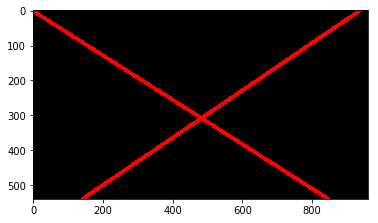

In [70]:
parent_dir = "test_images/"
output_dir = "test_images_output/"
img_list = os.listdir(parent_dir)
for img_tmp in img_list:
    print(img_tmp) 
    image = mpimg.imread(parent_dir+img_tmp)
    #     print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    mpimg.imsave(output_dir+img_tmp, lane_line_pipeline(image))
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [47]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [48]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return lane_line_pipeline(image)

Let's try the one with the solid white lane on the right first ...

points len:  132 225
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|          | 0/222 [00:00<?, ?it/s]

points len:  132 225
points len:  133 254


  1%|          | 2/222 [00:00<00:20, 10.66it/s]

points len:  102 238
points len:  72 

  2%|▏         | 4/222 [00:00<00:20, 10.60it/s]

260
points len:  29 200
points len:  24 226

  3%|▎         | 6/222 [00:00<00:20, 10.62it/s]


points len:  33 220
points len:  32 279


  4%|▎         | 8/222 [00:00<00:20, 10.62it/s]

points len:  50 210
points len:  56 314


  5%|▍         | 10/222 [00:00<00:20, 10.53it/s]

points len:  68 

  5%|▍         | 11/222 [00:01<00:20, 10.18it/s]

239
points len:  89 250


  6%|▌         | 13/222 [00:01<00:20, 10.25it/s]

points len:  128 250
points len:  135 241
points len:  128 210


  7%|▋         | 15/222 [00:01<00:20, 10.32it/s]

points len:  90 239
points len:  37 208


  8%|▊         | 17/222 [00:01<00:19, 10.33it/s]

points len:  23 244

  9%|▊         | 19/222 [00:01<00:19, 10.46it/s]


points len:  32 268
points len:  49 222
points len:  56 263


  9%|▉         | 21/222 [00:02<00:19, 10.50it/s]

points len:  55 248
points len:  64 226


 10%|█         | 23/222 [00:02<00:18, 10.57it/s]

points len:  101 207

 11%|█▏        | 25/222 [00:02<00:18, 10.58it/s]


points len:  140 254
points len:  125 188
points len:  

 12%|█▏        | 27/222 [00:02<00:18, 10.51it/s]

106 241
points len:  86 270
points len:  35

 13%|█▎        | 29/222 [00:02<00:18, 10.55it/s]

 240
points len:  25 261


 14%|█▍        | 31/222 [00:02<00:18, 10.60it/s]

points len:  34 214
points len:  39 231
points len:  47 291


 15%|█▍        | 33/222 [00:03<00:17, 10.65it/s]

points len:  57 249
points len:  70 255

 16%|█▌        | 35/222 [00:03<00:17, 10.56it/s]


points len:  88 

 17%|█▋        | 37/222 [00:03<00:17, 10.28it/s]

303
points len:  97 242
points len:  164 245
points len:  97 234


 18%|█▊        | 39/222 [00:03<00:17, 10.27it/s]

points len:  85 257


 18%|█▊        | 41/222 [00:03<00:17, 10.27it/s]

points len:  36 252
points len:  23 299
points len:  30 208


 19%|█▉        | 43/222 [00:04<00:17, 10.29it/s]

points len:  35 264
points len:  42 244


 20%|██        | 45/222 [00:04<00:17, 10.31it/s]

points len:  50 222


 21%|██        | 47/222 [00:04<00:16, 10.38it/s]

points len:  57 251
points len:  84 267


 22%|██▏       | 49/222 [00:04<00:18,  9.59it/s]

points len:  102 256
points len:  138 191


 23%|██▎       | 51/222 [00:04<00:17,  9.64it/s]

points len:  108 275
points len:  82 191
points len:  51 188


 25%|██▍       | 55/222 [00:05<00:16, 10.13it/s]

points len:  24 236
points len:  27 246
points len:  38 232


 26%|██▌       | 57/222 [00:05<00:15, 10.38it/s]

points len:  44 175
points len:  40 272
points len:  59 245


 27%|██▋       | 61/222 [00:05<00:15, 10.34it/s]

points len:  80 245
points len:  103 264
points len:  136 239


 28%|██▊       | 63/222 [00:06<00:15, 10.20it/s]

points len:  115 229
points len:  74 215
points len:  32 265


 30%|███       | 67/222 [00:06<00:14, 10.36it/s]

points len:  20 253
points len:  30 221
points len:  34 243


 31%|███       | 69/222 [00:06<00:14, 10.29it/s]

points len:  40 223
points len:  45 232


 33%|███▎      | 73/222 [00:07<00:14, 10.26it/s]

points len:  54 258
points len:  84 274
points len:  82 250
points len:  132 253


 34%|███▍      | 75/222 [00:07<00:14, 10.28it/s]

points len:  126 263
points len:  92 237
points len:  58 278


 36%|███▌      | 79/222 [00:07<00:13, 10.33it/s]

points len:  22 279
points len:  29 205
points len:  31 302


 36%|███▋      | 81/222 [00:07<00:13, 10.31it/s]

points len:  47 252
points len:  47 258
points len:  52 197

 38%|███▊      | 85/222 [00:08<00:13, 10.26it/s]


points len:  82 231
points len:  105 277
points len:  144 253


 39%|███▉      | 87/222 [00:08<00:13, 10.31it/s]

points len:  125 276
points len:  105 242
points len:  51 262


 41%|████      | 91/222 [00:08<00:12, 10.19it/s]

points len:  23 262
points len:  23 244
points len:  36 253


 42%|████▏     | 93/222 [00:09<00:12, 10.21it/s]

points len:  37 228
points len:  54 303
points len:  60 184


 44%|████▎     | 97/222 [00:09<00:11, 10.46it/s]

points len:  80 223
points len:  93 230
points len:  165 242


 45%|████▍     | 99/222 [00:09<00:11, 10.37it/s]

points len:  129 217
points len:  88 273
points len:  58 200


 46%|████▋     | 103/222 [00:09<00:11, 10.40it/s]

points len:  20 237
points len:  31 219
points len:  38 234


 47%|████▋     | 105/222 [00:10<00:11, 10.29it/s]

points len:  53 234
points len:  40 232
points len:  59 217


 49%|████▉     | 109/222 [00:10<00:10, 10.36it/s]

points len:  63 248
points len:  126 204
points len:  136 227

 50%|█████     | 111/222 [00:10<00:10, 10.29it/s]


points len:  113 230
points len:  112 239
points len:  51 227


 52%|█████▏    | 115/222 [00:11<00:10, 10.50it/s]

points len:  24 199
points len:  28 241
points len:  28 254


 53%|█████▎    | 117/222 [00:11<00:09, 10.55it/s]

points len:  40 257
points len:  47 230
points len:  57 269

 55%|█████▍    | 121/222 [00:11<00:09, 10.57it/s]


points len:  82 209
points len:  109 241
points len:  137 223


 55%|█████▌    | 123/222 [00:11<00:09, 10.41it/s]

points len:  133 269
points len:  103 241


 56%|█████▋    | 125/222 [00:12<00:09, 10.19it/s]

points len:  71 249
points len:  26 244
points len:  26 256


 58%|█████▊    | 129/222 [00:12<00:08, 10.44it/s]

points len:  35 264
points len:  41 247
points len:  54 230


 59%|█████▉    | 131/222 [00:12<00:08, 10.43it/s]

points len:  82 232
points len:  84 286


 60%|█████▉    | 133/222 [00:12<00:08, 10.09it/s]

points len:  114 251
points len:  143 214
points len:  143 285


 62%|██████▏   | 137/222 [00:13<00:08, 10.09it/s]

points len:  98 214
points len:  67 270


 63%|██████▎   | 139/222 [00:13<00:08, 10.05it/s]

points len:  19 234
points len:  28 229
points len:  32 216
points len:  44 258


 64%|██████▍   | 143/222 [00:13<00:07, 10.29it/s]

points len:  54 255
points len:  68 237
points len:  84 232


 65%|██████▌   | 145/222 [00:14<00:07, 10.23it/s]

points len:  107 248
points len:  126 216
points len:  128 241


 67%|██████▋   | 149/222 [00:14<00:07, 10.42it/s]

points len:  96 261
points len:  75 255
points len:  26 218


 68%|██████▊   | 151/222 [00:14<00:06, 10.42it/s]

points len:  26 204
points len:  44 193
points len:  45 193

 70%|██████▉   | 155/222 [00:15<00:06, 10.43it/s]


points len:  51 251
points len:  63 229
points len:  87 213


 71%|███████   | 157/222 [00:15<00:06, 10.51it/s]

points len:  97 262
points len:  126 234
points len:  124 221


 73%|███████▎  | 161/222 [00:15<00:05, 10.36it/s]

points len:  113 194
points len:  80 234
points len:  33 223


 73%|███████▎  | 163/222 [00:15<00:05, 10.41it/s]

points len:  44 208
points len:  34 217
points len:  45 264


 75%|███████▌  | 167/222 [00:16<00:05, 10.49it/s]

points len:  66 196
points len:  63 187
points len:  89 256


 76%|███████▌  | 169/222 [00:16<00:05, 10.29it/s]

points len:  110 239
points len:  137 265
points len:  148 247


 78%|███████▊  | 173/222 [00:16<00:04, 10.42it/s]

points len:  127 274
points len:  65 193
points len:  34 226


 79%|███████▉  | 175/222 [00:16<00:04, 10.51it/s]

points len:  30 303
points len:  45 163
points len:  41 

 81%|████████  | 179/222 [00:17<00:04, 10.59it/s]

290
points len:  49 237
points len:  60 240
points len:  83 242


 82%|████████▏ | 181/222 [00:17<00:03, 10.60it/s]

points len:  114 236
points len:  138 193
points len:  115 243


 83%|████████▎ | 185/222 [00:17<00:03, 10.53it/s]

points len:  108 281
points len:  69 201
points len:  28 217


 84%|████████▍ | 187/222 [00:18<00:03, 10.42it/s]

points len:  40 220
points len:  35 215
points len:  35 225

 86%|████████▌ | 191/222 [00:18<00:02, 10.42it/s]


points len:  61 170
points len:  57 174
points len:  69 143


 87%|████████▋ | 193/222 [00:18<00:02, 10.31it/s]

points len:  95 217
points len:  154 185
points len:  133 165

 89%|████████▊ | 197/222 [00:19<00:02, 10.20it/s]


points len:  109 224
points len:  65 202
points len:  28 235


 90%|████████▉ | 199/222 [00:19<00:02, 10.31it/s]

points len:  37 233
points len:  44 259
points len:  41 174


 91%|█████████▏| 203/222 [00:19<00:01, 10.32it/s]

points len:  40 182
points len:  56 191
points len:  82 226


 92%|█████████▏| 205/222 [00:19<00:01, 10.38it/s]

points len:  99 211
points len:  128 217
points len:  133 209


 94%|█████████▍| 209/222 [00:20<00:01, 10.16it/s]

points len:  98 235
points len:  66 280
points len:  26 227

 95%|█████████▌| 211/222 [00:20<00:01, 10.23it/s]


points len:  32 228
points len:  34 215
points len:  46 247


 97%|█████████▋| 215/222 [00:20<00:00, 10.18it/s]

points len:  58 216
points len:  81 239


 98%|█████████▊| 217/222 [00:21<00:00, 10.02it/s]

points len:  92 266
points len:  128 255
points len:  146 213


100%|█████████▉| 221/222 [00:21<00:00, 10.05it/s]


points len:  122 243
points len:  129 287
points len:  80 267
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 21 s, sys: 964 ms, total: 21.9 s
Wall time: 22.1 s


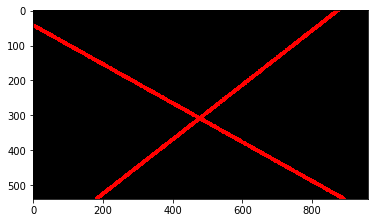

In [50]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

points len:  256 102
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 0/682 [00:00<?, ?it/s]

points len:  256 102


  0%|          | 2/682 [00:00<01:03, 10.75it/s]

points len:  247 138
points len:  280 

  0%|          | 3/682 [00:00<01:05, 10.38it/s]

115
points len:  282 87


  1%|          | 5/682 [00:00<01:04, 10.53it/s]

points len:  302 48
points len:  274 25
points len:  297 28


  1%|          | 7/682 [00:00<01:03, 10.58it/s]

points len:  266 34
points len:  296 44


  1%|▏         | 9/682 [00:00<01:02, 10.68it/s]

points len:  237 48


  2%|▏         | 11/682 [00:01<01:02, 10.76it/s]

points len:  216 54
points len:  224 59
points len:  245 73

  2%|▏         | 13/682 [00:01<01:02, 10.70it/s]


points len:  275 138
points len:  203 135

  2%|▏         | 15/682 [00:01<01:02, 10.66it/s]


points len:  237 128


  2%|▏         | 17/682 [00:01<01:02, 10.61it/s]

points len:  226 69
points len:  246 27
points len:  223

  3%|▎         | 19/682 [00:01<01:02, 10.58it/s]

 25
points len:  241 8
points len:  243 44


  3%|▎         | 21/682 [00:01<01:02, 10.57it/s]

points len:  286 

  3%|▎         | 23/682 [00:02<01:02, 10.51it/s]

49
points len:  273 61
points len:  178 60
points len:  231 92


  4%|▎         | 25/682 [00:02<01:02, 10.55it/s]

points len:  227 124
points len:  296 141

  4%|▍         | 27/682 [00:02<01:02, 10.55it/s]


points len:  262

  4%|▍         | 29/682 [00:02<01:01, 10.57it/s]

 97
points len:  295 87
points len:  216 40
points len:  192 6


  5%|▍         | 31/682 [00:02<01:01, 10.58it/s]

points len:  239 14
points len:  243 21


  5%|▍         | 33/682 [00:03<01:01, 10.60it/s]

points len:  253 38

  5%|▌         | 35/682 [00:03<01:02, 10.44it/s]


points len:  196 62
points len:  235 69
points len:  252 78

  5%|▌         | 37/682 [00:03<01:01, 10.43it/s]


points len:  224 89
points len:  221 118

  6%|▌         | 39/682 [00:03<01:02, 10.33it/s]


points len:  

  6%|▌         | 41/682 [00:03<01:02, 10.23it/s]

222 143
points len:  236 129
points len:  194 75
points len:  280 10

  6%|▋         | 43/682 [00:04<01:02, 10.21it/s]


points len:  203 7
points len:  204 29


  7%|▋         | 45/682 [00:04<01:01, 10.34it/s]

points len:  213 38


  7%|▋         | 47/682 [00:04<01:01, 10.37it/s]

points len:  259 47
points len:  197 54
points len:  251

  7%|▋         | 49/682 [00:04<01:00, 10.42it/s]

 71
points len:  225 64
points len:  250 98


  7%|▋         | 51/682 [00:04<01:00, 10.48it/s]

points len:  246

  8%|▊         | 53/682 [00:05<00:59, 10.50it/s]

 135
points len:  243 126
points len:  213 108
points len:  265 47


  8%|▊         | 55/682 [00:05<01:00, 10.42it/s]

points len:  243 14
points len:  222 27


  8%|▊         | 57/682 [00:05<00:59, 10.45it/s]

points len:  255 36


  9%|▊         | 59/682 [00:05<00:59, 10.47it/s]

points len:  287 44
points len:  231 47
points len:  245 59

  9%|▉         | 61/682 [00:05<01:00, 10.31it/s]


points len:  254 73


  9%|▉         | 63/682 [00:06<01:00, 10.22it/s]

points len:  265 105
points len:  266 151
points len:  249 105


 10%|▉         | 65/682 [00:06<01:00, 10.14it/s]

points len:  219 103
points len:  224 66

 10%|▉         | 67/682 [00:06<01:00, 10.23it/s]


points len:  240 28


 10%|█         | 69/682 [00:06<00:59, 10.25it/s]

points len:  243 63
points len:  266 36
points len:  227 43


 10%|█         | 71/682 [00:06<00:59, 10.23it/s]

points len:  247 51
points len:  197 40


 11%|█         | 73/682 [00:06<00:59, 10.28it/s]

points len:  245 62


 11%|█         | 75/682 [00:07<00:58, 10.31it/s]

points len:  218 78
points len:  273 102


 11%|█▏        | 77/682 [00:07<01:00,  9.97it/s]

points len:  277 131
points len:  250 142
points len:  200 101


 12%|█▏        | 79/682 [00:07<00:59, 10.12it/s]

points len:  224 64


 12%|█▏        | 81/682 [00:07<00:59, 10.17it/s]

points len:  265 17
points len:  224 25
points len:  233 44


 12%|█▏        | 83/682 [00:07<00:59, 10.14it/s]

points len:  209 34
points len:  274 52


 13%|█▎        | 87/682 [00:08<00:59, 10.01it/s]

points len:  230 57
points len:  233 71
points len:  232 85


 13%|█▎        | 90/682 [00:08<01:00,  9.79it/s]

points len:  271 132
points len:  197 141


 13%|█▎        | 92/682 [00:08<01:00,  9.77it/s]

points len:  246 146
points len:  266 114
points len:  250 85

 14%|█▍        | 95/682 [00:09<01:00,  9.74it/s]


points len:  237 30
points len:  279 36


 14%|█▍        | 97/682 [00:09<00:58,  9.99it/s]

points len:  308 36
points len:  233 36
points len:  251 46


 15%|█▍        | 99/682 [00:09<00:58, 10.03it/s]

points len:  199 54
points len:  251 49
points len:  221 68


 15%|█▌        | 103/682 [00:09<00:55, 10.37it/s]

points len:  243 101
points len:  263 134
points len:  237 126


 15%|█▌        | 105/682 [00:10<00:56, 10.15it/s]

points len:  278 98
points len:  259 57
points len:  287 17


 16%|█▌        | 109/682 [00:10<00:55, 10.39it/s]

points len:  265 27
points len:  227 31
points len:  190

 16%|█▋        | 111/682 [00:10<00:56, 10.17it/s]

 45
points len:  288 49
points len:  260 64
points len:  273 77

 17%|█▋        | 115/682 [00:11<00:55, 10.21it/s]


points len:  244 92
points len:  202 102
points len:  238 166


 17%|█▋        | 117/682 [00:11<00:55, 10.23it/s]

points len:  211 101
points len:  246 86
points len:  222 53

 18%|█▊        | 121/682 [00:11<00:54, 10.23it/s]


points len:  262 29
points len:  216 36
points len:  268 42


 18%|█▊        | 123/682 [00:11<00:54, 10.18it/s]

points len:  243 38
points len:  254 57
points len:  245 75


 19%|█▊        | 127/682 [00:12<00:54, 10.26it/s]

points len:  212 105
points len:  262 120
points len:  329 153


 19%|█▉        | 129/682 [00:12<00:53, 10.30it/s]

points len:  277 110
points len:  249 89
points len:  202 54

 20%|█▉        | 133/682 [00:12<00:53, 10.30it/s]


points len:  274 26
points len:  249 28


 20%|█▉        | 135/682 [00:13<00:52, 10.35it/s]

points len:  236 34
points len:  289 50
points len:  300 66


 20%|██        | 137/682 [00:13<00:53, 10.25it/s]

points len:  228 56
points len:  230 88


 20%|██        | 139/682 [00:13<00:53, 10.14it/s]

points len:  247 103
points len:  191 100
points len:  

 21%|██        | 143/682 [00:13<00:52, 10.21it/s]

262 129
points len:  241 131
points len:  235 81
points len:  244 34


 21%|██▏       | 145/682 [00:14<00:51, 10.33it/s]

points len:  252 29
points len:  276 34
points len:  254 29


 22%|██▏       | 149/682 [00:14<00:50, 10.48it/s]

points len:  253 50
points len:  249 60
points len:  250 61


 22%|██▏       | 151/682 [00:14<00:50, 10.43it/s]

points len:  288 78
points len:  277 101
points len:  241 139


 23%|██▎       | 155/682 [00:15<00:50, 10.42it/s]

points len:  258 130
points len:  261 76
points len:  251 56


 23%|██▎       | 157/682 [00:15<00:50, 10.37it/s]

points len:  237 24
points len:  319 24
points len:  277 41

 24%|██▎       | 161/682 [00:15<00:50, 10.40it/s]


points len:  283 54
points len:  223 51
points len:  262 62

 24%|██▍       | 163/682 [00:15<00:49, 10.40it/s]


points len:  267 77
points len:  273 108
points len:  259 120


 24%|██▍       | 167/682 [00:16<00:49, 10.35it/s]

points len:  251 135
points len:  253 88
points len:  298 77

 25%|██▍       | 169/682 [00:16<00:49, 10.43it/s]


points len:  298 29
points len:  273 24
points len:  261 29

 25%|██▌       | 173/682 [00:16<00:49, 10.31it/s]


points len:  232 40
points len:  203 43
points len:  216 56


 26%|██▌       | 175/682 [00:16<00:50, 10.10it/s]

points len:  251 68
points len:  227 82
points len:  218 94

 26%|██▌       | 179/682 [00:17<00:49, 10.21it/s]


points len:  237 133
points len:  225 152
points len:  280 93


 27%|██▋       | 181/682 [00:17<00:48, 10.30it/s]

points len:  237 37
points len:  285 14
points len:  242 18


 27%|██▋       | 185/682 [00:17<00:47, 10.48it/s]

points len:  196 36
points len:  290 41
points len:  272 61


 27%|██▋       | 187/682 [00:18<00:47, 10.52it/s]

points len:  241 66
points len:  274 82
points len:  244 106


 28%|██▊       | 191/682 [00:18<00:46, 10.52it/s]

points len:  260 128
points len:  239 122
points len:  273 122


 28%|██▊       | 193/682 [00:18<00:47, 10.29it/s]

points len:  282 65
points len:  233 27
points len:  264 22


 29%|██▉       | 197/682 [00:19<00:47, 10.12it/s]

points len:  261 45
points len:  254 59


 29%|██▉       | 199/682 [00:19<00:47, 10.14it/s]

points len:  241 64
points len:  244 63
points len:  244 78


 29%|██▉       | 201/682 [00:19<00:46, 10.31it/s]

points len:  268 97
points len:  251 91
points len:  228 164


 30%|███       | 205/682 [00:19<00:46, 10.34it/s]

points len:  255 142
points len:  252 97
points len:  247 43


 30%|███       | 207/682 [00:20<00:45, 10.34it/s]

points len:  256 30
points len:  252 38
points len:  277 43

 31%|███       | 211/682 [00:20<00:45, 10.34it/s]


points len:  285 50
points len:  239 61
points len:  298 67


 31%|███       | 213/682 [00:20<00:44, 10.45it/s]

points len:  267 87
points len:  271 116
points len:  254 146


 32%|███▏      | 217/682 [00:21<00:45, 10.17it/s]

points len:  263 121
points len:  229 112


 32%|███▏      | 219/682 [00:21<00:45, 10.27it/s]

points len:  268 61
points len:  275 30
points len:  264 36


 32%|███▏      | 221/682 [00:21<00:44, 10.37it/s]

points len:  281 38
points len:  282 44
points len:  225 

 33%|███▎      | 225/682 [00:21<00:44, 10.32it/s]

57
points len:  238 67
points len:  278 84
points len:  274 

 33%|███▎      | 227/682 [00:22<00:44, 10.28it/s]

97
points len:  239 124
points len:  237 130
points len:  197 123


 34%|███▍      | 231/682 [00:22<00:43, 10.47it/s]

points len:  251 78
points len:  225 35
points len:  255 27


 34%|███▍      | 233/682 [00:22<00:42, 10.46it/s]

points len:  232 34
points len:  235 41
points len:  202 56


 35%|███▍      | 237/682 [00:22<00:42, 10.47it/s]

points len:  287 57
points len:  243 49
points len:  247 78


 35%|███▌      | 239/682 [00:23<00:42, 10.47it/s]

points len:  260 109
points len:  289 153
points len:  242

 36%|███▌      | 243/682 [00:23<00:42, 10.39it/s]

 143
points len:  231 94
points len:  272 57
points len:  307 28


 36%|███▌      | 245/682 [00:23<00:42, 10.36it/s]

points len:  247 28
points len:  232 34
points len:  219 42


 37%|███▋      | 249/682 [00:24<00:41, 10.53it/s]

points len:  250 37
points len:  241 51
points len:  255 57

 37%|███▋      | 251/682 [00:24<00:41, 10.38it/s]


points len:  256 68
points len:  291 109
points len:  195 141


 37%|███▋      | 255/682 [00:24<00:46,  9.26it/s]

points len:  255 160
points len:  235 126
points len:  237 82


 38%|███▊      | 258/682 [00:25<00:43,  9.73it/s]

points len:  224 41
points len:  206 24
points len:  292 28


 38%|███▊      | 260/682 [00:25<00:42,  9.96it/s]

points len:  209 28
points len:  231 40
points len:  227 57


 39%|███▊      | 264/682 [00:25<00:41, 10.13it/s]

points len:  261 63
points len:  256 70
points len:  236 81


 39%|███▉      | 266/682 [00:25<00:41, 10.09it/s]

points len:  302 109
points len:  241 140
points len:  273 123


 40%|███▉      | 270/682 [00:26<00:40, 10.22it/s]

points len:  234 77
points len:  260 43
points len:  262 33

 40%|███▉      | 272/682 [00:26<00:39, 10.27it/s]


points len:  334 29
points len:  305 32
points len:  237

 40%|████      | 276/682 [00:26<00:39, 10.16it/s]

 39
points len:  243 50
points len:  293 62
points len:  260 86


 41%|████      | 278/682 [00:26<00:39, 10.26it/s]

points len:  247 104
points len:  292 150
points len:  250 133


 41%|████▏     | 282/682 [00:27<00:38, 10.32it/s]

points len:  276 106
points len:  184 70
points len:  248 34

 42%|████▏     | 284/682 [00:27<00:39, 10.12it/s]


points len:  208 47
points len:  248 40


 42%|████▏     | 286/682 [00:27<00:39, 10.11it/s]

points len:  246 58
points len:  262 74
points len:  280 77


 43%|████▎     | 290/682 [00:28<00:39, 10.02it/s]

points len:  258 106
points len:  226 155


 43%|████▎     | 292/682 [00:28<00:39,  9.90it/s]

points len:  264 177
points len:  249 150
points len:  270 134

 43%|████▎     | 294/682 [00:28<00:39,  9.71it/s]


points len:  208 70
points len:  269 33
points len:  240 34

 44%|████▎     | 298/682 [00:28<00:38, 10.02it/s]


points len:  236 40
points len:  264 47
points len:  244 70


 44%|████▍     | 300/682 [00:29<00:37, 10.11it/s]

points len:  254 59
points len:  305 81
points len:  236 85

 45%|████▍     | 304/682 [00:29<00:36, 10.27it/s]


points len:  231 117
points len:  310 133
points len:  299 91


 45%|████▍     | 306/682 [00:29<00:36, 10.30it/s]

points len:  221 78
points len:  219 34
points len:  245 

 45%|████▌     | 310/682 [00:30<00:35, 10.44it/s]

29
points len:  235 32
points len:  271 37
points len:  241 

 46%|████▌     | 312/682 [00:30<00:36, 10.22it/s]

47
points len:  262 55
points len:  226 67
points len:  217 81


 46%|████▋     | 316/682 [00:30<00:35, 10.33it/s]

points len:  238 103
points len:  211 150
points len:  238 

 47%|████▋     | 318/682 [00:30<00:35, 10.17it/s]

113
points len:  229 90
points len:  259 44


 47%|████▋     | 320/682 [00:31<00:35, 10.08it/s]

points len:  226 26
points len:  239 33
points len:  237 43


 48%|████▊     | 324/682 [00:31<00:35, 10.18it/s]

points len:  221 51
points len:  266 55
points len:  247 87


 48%|████▊     | 326/682 [00:31<00:35, 10.08it/s]

points len:  280 87
points len:  233 123
points len:  283 153


 48%|████▊     | 330/682 [00:32<00:34, 10.21it/s]

points len:  238 129
points len:  233 101
points len:  261 65


 49%|████▊     | 332/682 [00:32<00:34, 10.23it/s]

points len:  225 26
points len:  211 30
points len:  251 39

 49%|████▉     | 336/682 [00:32<00:34, 10.17it/s]


points len:  253 48
points len:  261 57
points len:  253

 50%|████▉     | 338/682 [00:32<00:34, 10.09it/s]

 88
points len:  238 79
points len:  277 115


 50%|████▉     | 340/682 [00:33<00:34,  9.96it/s]

points len:  225 155
points len:  274 144
points len:  264 113


 50%|█████     | 344/682 [00:33<00:33, 10.23it/s]

points len:  267 51
points len:  249 21
points len:  261 32


 51%|█████     | 346/682 [00:33<00:32, 10.33it/s]

points len:  260 36
points len:  310 45
points len:  302 58


 51%|█████▏    | 350/682 [00:34<00:32, 10.27it/s]

points len:  301 72
points len:  285 88
points len:  313 121

 52%|█████▏    | 352/682 [00:34<00:32, 10.17it/s]


points len:  275 155
points len:  240 164
points len:  268 107

 52%|█████▏    | 356/682 [00:34<00:31, 10.47it/s]


points len:  245 62
points len:  252 23
points len:  287 29


 52%|█████▏    | 358/682 [00:34<00:30, 10.48it/s]

points len:  268 35
points len:  238 45
points len:  257 64


 53%|█████▎    | 362/682 [00:35<00:30, 10.53it/s]

points len:  258 65
points len:  210 81
points len:  227 113


 53%|█████▎    | 364/682 [00:35<00:30, 10.46it/s]

points len:  271 140
points len:  245 131
points len:  244 108


 54%|█████▍    | 368/682 [00:35<00:30, 10.37it/s]

points len:  254 71
points len:  279 36
points len:  234 32


 54%|█████▍    | 370/682 [00:35<00:30, 10.36it/s]

points len:  239 49
points len:  197 47
points len:  224 64


 55%|█████▍    | 374/682 [00:36<00:29, 10.34it/s]

points len:  230 79
points len:  243 71
points len:  217 110

 55%|█████▌    | 376/682 [00:36<00:29, 10.35it/s]


points len:  259 134
points len:  236 138
points len:  251 122

 56%|█████▌    | 380/682 [00:36<00:29, 10.22it/s]


points len:  252 103
points len:  253 36
points len:  234

 56%|█████▌    | 382/682 [00:37<00:29, 10.19it/s]

 40
points len:  206 36
points len:  212 53
points len:  240 68


 57%|█████▋    | 386/682 [00:37<00:28, 10.27it/s]

points len:  232 70
points len:  302 92
points len:  246 102

 57%|█████▋    | 388/682 [00:37<00:28, 10.33it/s]


points len:  249 114
points len:  243 145
points len:  219 129

 57%|█████▋    | 392/682 [00:38<00:27, 10.38it/s]


points len:  233 86
points len:  269 45
points len:  231 31


 58%|█████▊    | 394/682 [00:38<00:27, 10.30it/s]

points len:  240 40
points len:  263 51


 58%|█████▊    | 396/682 [00:38<00:28, 10.11it/s]

points len:  234 60
points len:  246 51
points len:  267 76


 59%|█████▊    | 400/682 [00:38<00:28, 10.01it/s]

points len:  207 92
points len:  231 124


 59%|█████▉    | 402/682 [00:39<00:28,  9.89it/s]

points len:  260 148
points len:  231 110


 59%|█████▉    | 405/682 [00:39<00:28,  9.83it/s]

points len:  235 105
points len:  234 51
points len:  208 34
points len:  236 36


 60%|█████▉    | 407/682 [00:39<00:27, 10.01it/s]

points len:  252 42
points len:  259 65
points len:  300 48


 60%|██████    | 411/682 [00:40<00:26, 10.32it/s]

points len:  228 68
points len:  282 98
points len:  246 126


 61%|██████    | 413/682 [00:40<00:26, 10.30it/s]

points len:  212 144
points len:  268 115
points len:  250 110


 61%|██████    | 417/682 [00:40<00:25, 10.25it/s]

points len:  276 68
points len:  266 26
points len:  252 

 61%|██████▏   | 419/682 [00:40<00:25, 10.26it/s]

31
points len:  236 42
points len:  252 50
points len:  208 

 62%|██████▏   | 423/682 [00:41<00:25, 10.17it/s]

66
points len:  301 81
points len:  189 89
points len:  289 130


 62%|██████▏   | 425/682 [00:41<00:25, 10.06it/s]

points len:  263 135
points len:  189 147
points len:  284 116


 63%|██████▎   | 429/682 [00:41<00:24, 10.14it/s]

points len:  243 77
points len:  277 27
points len:  224 28

 63%|██████▎   | 431/682 [00:41<00:24, 10.24it/s]


points len:  294 41
points len:  214 44
points len:  276 45


 64%|██████▍   | 435/682 [00:42<00:23, 10.32it/s]

points len:  241 83
points len:  239 96
points len:  253 100


 64%|██████▍   | 437/682 [00:42<00:23, 10.30it/s]

points len:  235 134
points len:  275 131
points len:  229 90


 65%|██████▍   | 441/682 [00:42<00:23, 10.24it/s]

points len:  267 71
points len:  259 35
points len:  242 27


 65%|██████▍   | 443/682 [00:43<00:23, 10.21it/s]

points len:  274 32
points len:  255 35
points len:  262 49

 66%|██████▌   | 447/682 [00:43<00:23, 10.08it/s]


points len:  227 67
points len:  242 59


 66%|██████▌   | 449/682 [00:43<00:23, 10.09it/s]

points len:  252 81
points len:  242 86
points len:  264 121


 66%|██████▌   | 451/682 [00:43<00:22, 10.10it/s]

points len:  217 126
points len:  210 117
points len:  231 87


 67%|██████▋   | 455/682 [00:44<00:22, 10.24it/s]

points len:  235 45
points len:  232 23
points len:  267 32


 67%|██████▋   | 457/682 [00:44<00:21, 10.24it/s]

points len:  229 34
points len:  228 54


 67%|██████▋   | 459/682 [00:44<00:22, 10.10it/s]

points len:  254 53
points len:  211 62
points len:  237 88


 68%|██████▊   | 463/682 [00:45<00:21, 10.23it/s]

points len:  247 89
points len:  248 111
points len:  

 68%|██████▊   | 465/682 [00:45<00:21, 10.18it/s]

258 115
points len:  257 88
points len:  239 54


 69%|██████▉   | 469/682 [00:45<00:21, 10.11it/s]

points len:  204 25
points len:  296 24
points len:  255 35
points len:  276 53


 69%|██████▉   | 471/682 [00:45<00:20, 10.06it/s]

points len:  267 56
points len:  270 67
points len: 

 69%|██████▉   | 473/682 [00:46<00:20, 10.07it/s]

 274 77
points len:  223 146
points len:  269 166


 70%|██████▉   | 477/682 [00:46<00:20,  9.93it/s]

points len:  231 155
points len:  249 124


 70%|███████   | 478/682 [00:46<00:20,  9.87it/s]

points len:  198 62
points len:  265 33
points len:  249 34


 71%|███████   | 482/682 [00:47<00:19, 10.19it/s]

points len:  275 36
points len:  280 47
points len:  257 58

 71%|███████   | 484/682 [00:47<00:19, 10.11it/s]


points len:  259 55
points len:  235 73
points len:  252 89


 72%|███████▏  | 488/682 [00:47<00:18, 10.32it/s]

points len:  244 89
points len:  192 143
points len:  262 127


 72%|███████▏  | 490/682 [00:47<00:18, 10.11it/s]

points len:  287 76
points len:  241 39


 72%|███████▏  | 492/682 [00:47<00:18, 10.07it/s]

points len:  251 23
points len:  255 32
points len:  232 43


 73%|███████▎  | 496/682 [00:48<00:18, 10.00it/s]

points len:  249 49
points len:  285 64


 73%|███████▎  | 498/682 [00:48<00:18, 10.11it/s]

points len:  245 63
points len:  211 80
points len:  229 136


 73%|███████▎  | 500/682 [00:48<00:18, 10.04it/s]

points len:  224 153
points len:  289 106
points len:  223 97


 74%|███████▍  | 504/682 [00:49<00:17, 10.26it/s]

points len:  263 42
points len:  231 26
points len:  286 

 74%|███████▍  | 506/682 [00:49<00:17, 10.18it/s]

20
points len:  260 37
points len:  240 48


 74%|███████▍  | 508/682 [00:49<00:17, 10.02it/s]

points len:  247 43
points len:  296 68
points len:  248 83


 75%|███████▌  | 512/682 [00:49<00:16, 10.20it/s]

points len:  264 124
points len:  263 129
points len:  270 119


 75%|███████▌  | 514/682 [00:50<00:16, 10.24it/s]

points len:  266 105
points len:  228 64
points len:  244 24

 76%|███████▌  | 518/682 [00:50<00:15, 10.31it/s]


points len:  251 30
points len:  257 42
points len:  233 48


 76%|███████▌  | 520/682 [00:50<00:15, 10.35it/s]

points len:  285 69
points len:  264 65
points len:  254 78


 77%|███████▋  | 524/682 [00:51<00:15, 10.43it/s]

points len:  265 108
points len:  216 134
points len:  272 127


 77%|███████▋  | 526/682 [00:51<00:15, 10.31it/s]

points len:  279 111
points len:  222 77
points len:  231 27

 78%|███████▊  | 530/682 [00:51<00:14, 10.25it/s]


points len:  238 30
points len:  244 31
points len:  295 39

 78%|███████▊  | 532/682 [00:51<00:14, 10.25it/s]


points len:  266 51
points len:  270 53
points len:  240 67


 79%|███████▊  | 536/682 [00:52<00:14, 10.08it/s]

points len:  245 89
points len:  266 117
points len:  272 154


 79%|███████▉  | 539/682 [00:52<00:14,  9.88it/s]

points len:  265 138
points len:  270 77
points len:  259 42

 79%|███████▉  | 541/682 [00:52<00:13, 10.10it/s]


points len:  269 22
points len:  264 29
points len:  270 33

 80%|███████▉  | 545/682 [00:53<00:13, 10.06it/s]


points len:  311 47
points len:  247 50


 80%|████████  | 547/682 [00:53<00:13, 10.07it/s]

points len:  282 59
points len:  276 78
points len:  263 104


 80%|████████  | 549/682 [00:53<00:13, 10.06it/s]

points len:  272 109
points len:  250 124
points len:  273 88


 81%|████████  | 553/682 [00:53<00:12, 10.07it/s]

points len:  275 65
points len:  279 25
points len:  273 

 81%|████████▏ | 555/682 [00:54<00:12, 10.06it/s]

28
points len:  236 23
points len:  243 44
points len:  275 49


 82%|████████▏ | 559/682 [00:54<00:11, 10.32it/s]

points len:  250 56
points len:  214 85
points len:  265 100


 82%|████████▏ | 561/682 [00:54<00:11, 10.19it/s]

points len:  222 110
points len:  263 134
points len:  225 115


 83%|████████▎ | 565/682 [00:55<00:11, 10.30it/s]

points len:  252 63
points len:  251 27
points len:  287

 83%|████████▎ | 567/682 [00:55<00:11, 10.18it/s]

 18
points len:  223 40
points len:  212 17
points len:  298 

 84%|████████▎ | 571/682 [00:55<00:10, 10.36it/s]

48
points len:  281 52
points len:  264 50
points len:  246 89

 84%|████████▍ | 573/682 [00:55<00:10, 10.16it/s]


points len:  259 113
points len:  210 128
points len:  240 123


 85%|████████▍ | 577/682 [00:56<00:10, 10.22it/s]

points len:  242 96
points len:  237 44
points len:  252 12


 85%|████████▍ | 579/682 [00:56<00:09, 10.34it/s]

points len:  234 13
points len:  228 32
points len:  239 39


 85%|████████▌ | 583/682 [00:56<00:09, 10.41it/s]

points len:  220 45
points len:  219 61
points len:  275 77


 86%|████████▌ | 585/682 [00:57<00:09, 10.16it/s]

points len:  254 97
points len:  269 139


 86%|████████▌ | 588/682 [00:57<00:09,  9.49it/s]

points len:  275 131
points len:  259 120


 87%|████████▋ | 590/682 [00:57<00:09,  9.66it/s]

points len:  219 68
points len:  274 18
points len:  232 19


 87%|████████▋ | 593/682 [00:57<00:09,  9.36it/s]

points len:  279 32
points len:  325 38


 87%|████████▋ | 594/682 [00:58<00:09,  9.54it/s]

points len:  246 64
points len:  217 60
points len:  300 61


 88%|████████▊ | 597/682 [00:58<00:08,  9.70it/s]

points len:  279 70
points len:  275 112
points len:  267 152


 88%|████████▊ | 601/682 [00:58<00:08,  9.78it/s]

points len:  278 122
points len:  238 76


 88%|████████▊ | 603/682 [00:58<00:08,  9.84it/s]

points len:  224 45
points len:  265 22


 89%|████████▊ | 605/682 [00:59<00:07,  9.83it/s]

points len:  239 23
points len:  199 31
points len:  308

 89%|████████▉ | 608/682 [00:59<00:07, 10.03it/s]

 49
points len:  270 47
points len:  247 64
points len:  201 88


 89%|████████▉ | 610/682 [00:59<00:07, 10.12it/s]

points len:  199 107
points len:  282 141


 90%|████████▉ | 613/682 [01:00<00:07,  9.71it/s]

points len:  274 130
points len:  274 101
points len:  240 65

 90%|█████████ | 616/682 [01:00<00:06,  9.88it/s]


points len:  221 18
points len:  240 30


 91%|█████████ | 618/682 [01:00<00:06,  9.72it/s]

points len:  276 34
points len:  248 42
points len:  222 59


 91%|█████████ | 621/682 [01:00<00:06, 10.02it/s]

points len:  223 41
points len:  253 70
points len:  248 82


 91%|█████████▏| 623/682 [01:00<00:05, 10.10it/s]

points len:  232 103
points len:  237 131


 92%|█████████▏| 625/682 [01:01<00:05,  9.97it/s]

points len:  243 115
points len:  177 62
points len:  280 32


 92%|█████████▏| 629/682 [01:01<00:05,  9.99it/s]

points len:  241 16
points len:  213 33


 93%|█████████▎| 631/682 [01:01<00:05,  9.72it/s]

points len:  222 44
points len:  275 51
points len:  272 42


 93%|█████████▎| 633/682 [01:01<00:04,  9.96it/s]

points len:  197 63
points len:  252 95
points len:  295 99

 93%|█████████▎| 637/682 [01:02<00:04, 10.11it/s]


points len:  231 145
points len:  244 130
points len:  268 86


 94%|█████████▎| 639/682 [01:02<00:04, 10.13it/s]

points len:  245 51
points len:  184 24
points len:  233 30


 94%|█████████▍| 643/682 [01:02<00:03, 10.40it/s]

points len:  194 28
points len:  198 51
points len:  238 50


 95%|█████████▍| 645/682 [01:03<00:03, 10.29it/s]

points len:  248 66
points len:  272 79
points len:  265 105

 95%|█████████▌| 649/682 [01:03<00:03, 10.15it/s]


points len:  237 135
points len:  279 130


 95%|█████████▌| 651/682 [01:03<00:03, 10.10it/s]

points len:  278 105
points len:  259 92
points len:  190 40


 96%|█████████▌| 653/682 [01:03<00:02, 10.23it/s]

points len:  210 28
points len:  218 32
points len:  222 37


 96%|█████████▋| 657/682 [01:04<00:02, 10.33it/s]

points len:  254 47
points len:  279 45
points len:  265 75


 97%|█████████▋| 659/682 [01:04<00:02,  8.83it/s]

points len:  273 87
points len:  229 101
points len:  224 150


 97%|█████████▋| 663/682 [01:05<00:01,  9.57it/s]

points len:  243 115
points len:  235 81
points len:  228 44


 98%|█████████▊| 665/682 [01:05<00:01,  9.90it/s]

points len:  231 18
points len:  290 57
points len:  213 58

 98%|█████████▊| 669/682 [01:05<00:01, 10.11it/s]


points len:  254 46
points len:  241 84
points len:  265 97

 98%|█████████▊| 671/682 [01:05<00:01, 10.06it/s]


points len:  230 117
points len:  217 92
points len:  278 132


 99%|█████████▉| 675/682 [01:06<00:00, 10.21it/s]

points len:  216 138
points len:  257 88
points len:  246 67


 99%|█████████▉| 677/682 [01:06<00:00, 10.17it/s]

points len:  233 28
points len:  255 27
points len:  289 36


100%|█████████▉| 681/682 [01:06<00:00, 10.30it/s]


points len:  259 47
points len:  292 61
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 1min 5s, sys: 2.3 s, total: 1min 8s
Wall time: 1min 7s


In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

hough_lines: 107
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 2/251 [00:00<00:29,  8.55it/s]

hough_lines: 107
hough_lines: 95


  2%|▏         | 4/251 [00:00<00:29,  8.49it/s]

hough_lines: 99
hough_lines: 85


  2%|▏         | 6/251 [00:00<00:28,  8.50it/s]

hough_lines: 90
hough_lines: 112


  3%|▎         | 8/251 [00:00<00:28,  8.51it/s]

hough_lines: 104
hough_lines: 87


  4%|▍         | 10/251 [00:01<00:28,  8.31it/s]

hough_lines: 101
hough_lines: 82


  5%|▍         | 12/251 [00:01<00:28,  8.31it/s]

hough_lines: 91
hough_lines: 113


  6%|▌         | 14/251 [00:01<00:28,  8.32it/s]

hough_lines: 116
hough_lines: 111


  6%|▋         | 16/251 [00:01<00:28,  8.39it/s]

hough_lines: 111
hough_lines: 90


  7%|▋         | 18/251 [00:02<00:27,  8.32it/s]

hough_lines: 99
hough_lines: 97


  8%|▊         | 20/251 [00:02<00:27,  8.51it/s]

hough_lines: 94
hough_lines: 88


  9%|▉         | 22/251 [00:02<00:26,  8.50it/s]

hough_lines: 87
hough_lines: 91


 10%|▉         | 24/251 [00:02<00:27,  8.39it/s]

hough_lines: 96
hough_lines: 105


 10%|█         | 26/251 [00:03<00:26,  8.39it/s]

hough_lines: 107
hough_lines: 118


 11%|█         | 28/251 [00:03<00:26,  8.31it/s]

hough_lines: 94
hough_lines: 113


 12%|█▏        | 30/251 [00:03<00:26,  8.33it/s]

hough_lines: 88
hough_lines: 116


 13%|█▎        | 32/251 [00:03<00:26,  8.36it/s]

hough_lines: 113
hough_lines: 101


 14%|█▎        | 34/251 [00:04<00:25,  8.35it/s]

hough_lines: 106
hough_lines: 94


 14%|█▍        | 36/251 [00:04<00:25,  8.32it/s]

hough_lines: 102
hough_lines: 122


 15%|█▌        | 38/251 [00:04<00:25,  8.33it/s]

hough_lines: 105
hough_lines: 105


 16%|█▌        | 39/251 [00:04<00:25,  8.33it/s]

hough_lines: 109


 16%|█▋        | 41/251 [00:04<00:29,  7.19it/s]

hough_lines: 102
hough_lines: 98


 17%|█▋        | 43/251 [00:05<00:27,  7.66it/s]

hough_lines: 95
hough_lines: 107


 18%|█▊        | 45/251 [00:05<00:25,  8.01it/s]

hough_lines: 86
hough_lines: 93


 19%|█▊        | 47/251 [00:05<00:25,  8.06it/s]

hough_lines: 97
hough_lines: 100


 20%|█▉        | 49/251 [00:05<00:24,  8.15it/s]

hough_lines: 93
hough_lines: 103


 20%|██        | 51/251 [00:06<00:24,  8.10it/s]

hough_lines: 102
hough_lines: 114


 21%|██        | 53/251 [00:06<00:23,  8.32it/s]

hough_lines: 104
hough_lines: 88


 22%|██▏       | 55/251 [00:06<00:23,  8.36it/s]

hough_lines: 104
hough_lines: 114


 23%|██▎       | 57/251 [00:06<00:23,  8.41it/s]

hough_lines: 113
hough_lines: 101


 24%|██▎       | 59/251 [00:07<00:22,  8.42it/s]

hough_lines: 107
hough_lines: 97


 24%|██▍       | 61/251 [00:07<00:22,  8.45it/s]

hough_lines: 118
hough_lines: 110


 25%|██▌       | 63/251 [00:07<00:22,  8.42it/s]

hough_lines: 139
hough_lines: 125


 26%|██▌       | 65/251 [00:07<00:22,  8.09it/s]

hough_lines: 119
hough_lines: 108


 27%|██▋       | 67/251 [00:08<00:22,  8.03it/s]

hough_lines: 115
hough_lines: 108


 27%|██▋       | 69/251 [00:08<00:22,  8.05it/s]

hough_lines: 103
hough_lines: 95


 28%|██▊       | 71/251 [00:08<00:22,  8.13it/s]

hough_lines: 95
hough_lines: 99


 29%|██▉       | 73/251 [00:08<00:22,  7.98it/s]

hough_lines: 110
hough_lines: 99


 30%|██▉       | 75/251 [00:09<00:22,  7.93it/s]

hough_lines: 115
hough_lines: 86


 31%|███       | 77/251 [00:09<00:22,  7.89it/s]

hough_lines: 92
hough_lines: 102


 31%|███▏      | 79/251 [00:09<00:22,  7.71it/s]

hough_lines: 131
hough_lines: 127


 32%|███▏      | 81/251 [00:09<00:21,  7.83it/s]

hough_lines: 111
hough_lines: 107


 33%|███▎      | 83/251 [00:10<00:21,  7.89it/s]

hough_lines: 114
hough_lines: 104


 34%|███▍      | 85/251 [00:10<00:20,  7.98it/s]

hough_lines: 128
hough_lines: 132


 35%|███▍      | 87/251 [00:10<00:20,  7.82it/s]

hough_lines: 160
hough_lines: 140


 35%|███▌      | 89/251 [00:10<00:20,  7.81it/s]

hough_lines: 206
hough_lines: 226


 36%|███▋      | 91/251 [00:11<00:20,  7.71it/s]

hough_lines: 284
hough_lines: 258


 37%|███▋      | 93/251 [00:11<00:20,  7.62it/s]

hough_lines: 319
hough_lines: 331


 38%|███▊      | 95/251 [00:11<00:19,  7.84it/s]

hough_lines: 305
hough_lines: 299


 39%|███▊      | 97/251 [00:11<00:20,  7.67it/s]

hough_lines: 283
hough_lines: 360


 39%|███▉      | 99/251 [00:12<00:19,  7.80it/s]

hough_lines: 308
hough_lines: 244


 40%|████      | 101/251 [00:12<00:18,  7.92it/s]

hough_lines: 198
hough_lines: 205


 41%|████      | 103/251 [00:12<00:18,  8.06it/s]

hough_lines: 185
hough_lines: 153


 42%|████▏     | 105/251 [00:12<00:18,  7.90it/s]

hough_lines: 176
hough_lines: 142


 43%|████▎     | 107/251 [00:13<00:18,  7.85it/s]

hough_lines: 190
hough_lines: 245


 43%|████▎     | 109/251 [00:13<00:18,  7.79it/s]

hough_lines: 332
hough_lines: 381


 44%|████▍     | 111/251 [00:13<00:17,  7.80it/s]

hough_lines: 318
hough_lines: 240


 45%|████▌     | 113/251 [00:13<00:17,  8.01it/s]

hough_lines: 225
hough_lines: 186


 46%|████▌     | 115/251 [00:14<00:16,  8.19it/s]

hough_lines: 128
hough_lines: 135


 47%|████▋     | 117/251 [00:14<00:17,  7.80it/s]

hough_lines: 129
hough_lines: 134


 47%|████▋     | 119/251 [00:14<00:16,  7.99it/s]

hough_lines: 102
hough_lines: 96


 48%|████▊     | 121/251 [00:14<00:16,  7.96it/s]

hough_lines: 102
hough_lines: 93


 49%|████▉     | 123/251 [00:15<00:16,  7.99it/s]

hough_lines: 82
hough_lines: 69


 50%|████▉     | 125/251 [00:15<00:15,  8.13it/s]

hough_lines: 97
hough_lines: 87


 51%|█████     | 127/251 [00:15<00:15,  7.89it/s]

hough_lines: 105
hough_lines: 102


 51%|█████▏    | 129/251 [00:15<00:15,  7.94it/s]

hough_lines: 101
hough_lines: 98


 52%|█████▏    | 131/251 [00:16<00:14,  8.08it/s]

hough_lines: 83
hough_lines: 90


 53%|█████▎    | 133/251 [00:16<00:14,  7.97it/s]

hough_lines: 99
hough_lines: 92


 54%|█████▍    | 135/251 [00:16<00:14,  7.82it/s]

hough_lines: 118
hough_lines: 115


 55%|█████▍    | 137/251 [00:17<00:15,  7.55it/s]

hough_lines: 131
hough_lines: 112


 55%|█████▌    | 139/251 [00:17<00:15,  7.32it/s]

hough_lines: 122
hough_lines: 121


 56%|█████▌    | 141/251 [00:17<00:14,  7.40it/s]

hough_lines: 155
hough_lines: 165


 57%|█████▋    | 143/251 [00:17<00:14,  7.63it/s]

hough_lines: 168
hough_lines: 185


 58%|█████▊    | 145/251 [00:18<00:14,  7.53it/s]

hough_lines: 236
hough_lines: 246


 59%|█████▊    | 147/251 [00:18<00:14,  7.41it/s]

hough_lines: 373
hough_lines: 485


 59%|█████▉    | 149/251 [00:18<00:14,  7.25it/s]

hough_lines: 514
hough_lines: 481


 60%|██████    | 151/251 [00:18<00:13,  7.53it/s]

hough_lines: 263
hough_lines: 185


 61%|██████    | 153/251 [00:19<00:12,  7.57it/s]

hough_lines: 140
hough_lines: 160


 62%|██████▏   | 155/251 [00:19<00:12,  7.70it/s]

hough_lines: 220
hough_lines: 177


 63%|██████▎   | 157/251 [00:19<00:12,  7.59it/s]

hough_lines: 136
hough_lines: 112


 63%|██████▎   | 159/251 [00:19<00:11,  7.97it/s]

hough_lines: 115
hough_lines: 120


 64%|██████▍   | 161/251 [00:20<00:11,  8.05it/s]

hough_lines: 108
hough_lines: 73


 65%|██████▍   | 163/251 [00:20<00:11,  7.78it/s]

hough_lines: 99
hough_lines: 70


 66%|██████▌   | 165/251 [00:20<00:10,  7.90it/s]

hough_lines: 58
hough_lines: 46


 67%|██████▋   | 167/251 [00:20<00:10,  8.00it/s]

hough_lines: 52
hough_lines: 88


 67%|██████▋   | 169/251 [00:21<00:10,  7.84it/s]

hough_lines: 78
hough_lines: 88


 68%|██████▊   | 171/251 [00:21<00:10,  7.92it/s]

hough_lines: 74
hough_lines: 83


 69%|██████▉   | 173/251 [00:21<00:09,  7.83it/s]

hough_lines: 88
hough_lines: 99


 70%|██████▉   | 175/251 [00:21<00:09,  7.85it/s]

hough_lines: 88
hough_lines: 88


 71%|███████   | 177/251 [00:22<00:09,  7.82it/s]

hough_lines: 102
hough_lines: 95


 71%|███████▏  | 179/251 [00:22<00:09,  7.65it/s]

hough_lines: 95
hough_lines: 96


 72%|███████▏  | 181/251 [00:22<00:09,  7.50it/s]

hough_lines: 100
hough_lines: 96


 73%|███████▎  | 183/251 [00:23<00:08,  7.77it/s]

hough_lines: 83
hough_lines: 90


 74%|███████▎  | 185/251 [00:23<00:08,  7.76it/s]

hough_lines: 91
hough_lines: 101


 75%|███████▍  | 187/251 [00:23<00:08,  8.00it/s]

hough_lines: 90
hough_lines: 92


 75%|███████▌  | 189/251 [00:23<00:07,  7.91it/s]

hough_lines: 94
hough_lines: 108


 76%|███████▌  | 191/251 [00:24<00:07,  7.91it/s]

hough_lines: 82
hough_lines: 93


 77%|███████▋  | 193/251 [00:24<00:07,  8.07it/s]

hough_lines: 90
hough_lines: 91


 78%|███████▊  | 195/251 [00:24<00:06,  8.16it/s]

hough_lines: 94
hough_lines: 100


 78%|███████▊  | 197/251 [00:24<00:06,  8.05it/s]

hough_lines: 84
hough_lines: 94


 79%|███████▉  | 199/251 [00:25<00:06,  7.56it/s]

hough_lines: 83
hough_lines: 112


 80%|████████  | 201/251 [00:25<00:06,  7.72it/s]

hough_lines: 96
hough_lines: 86


 81%|████████  | 203/251 [00:25<00:06,  7.79it/s]

hough_lines: 97
hough_lines: 95


 82%|████████▏ | 205/251 [00:25<00:05,  7.86it/s]

hough_lines: 98
hough_lines: 84


 82%|████████▏ | 207/251 [00:26<00:05,  8.09it/s]

hough_lines: 99
hough_lines: 94


 83%|████████▎ | 209/251 [00:26<00:05,  8.03it/s]

hough_lines: 107
hough_lines: 83


 84%|████████▍ | 211/251 [00:26<00:04,  8.04it/s]

hough_lines: 96
hough_lines: 95


 85%|████████▍ | 213/251 [00:26<00:04,  8.18it/s]

hough_lines: 104
hough_lines: 84


 86%|████████▌ | 215/251 [00:27<00:04,  7.95it/s]

hough_lines: 102
hough_lines: 122


 86%|████████▋ | 217/251 [00:27<00:04,  7.99it/s]

hough_lines: 89
hough_lines: 82


 87%|████████▋ | 219/251 [00:27<00:04,  7.98it/s]

hough_lines: 89
hough_lines: 76


 88%|████████▊ | 221/251 [00:27<00:03,  8.05it/s]

hough_lines: 92
hough_lines: 96


 89%|████████▉ | 223/251 [00:28<00:03,  8.00it/s]

hough_lines: 82
hough_lines: 96


 90%|████████▉ | 225/251 [00:28<00:03,  8.10it/s]

hough_lines: 104
hough_lines: 118


 90%|█████████ | 227/251 [00:28<00:02,  8.08it/s]

hough_lines: 86
hough_lines: 91


 91%|█████████ | 229/251 [00:28<00:02,  8.17it/s]

hough_lines: 80
hough_lines: 91


 92%|█████████▏| 231/251 [00:29<00:02,  8.32it/s]

hough_lines: 108
hough_lines: 97


 93%|█████████▎| 233/251 [00:29<00:02,  8.21it/s]

hough_lines: 99
hough_lines: 89


 94%|█████████▎| 235/251 [00:29<00:01,  8.21it/s]

hough_lines: 82
hough_lines: 85


 94%|█████████▍| 237/251 [00:29<00:01,  8.21it/s]

hough_lines: 82
hough_lines: 83


 95%|█████████▌| 239/251 [00:29<00:01,  8.17it/s]

hough_lines: 90
hough_lines: 85


 96%|█████████▌| 241/251 [00:30<00:01,  8.29it/s]

hough_lines: 88
hough_lines: 96


 97%|█████████▋| 243/251 [00:30<00:00,  8.35it/s]

hough_lines: 85
hough_lines: 90


 98%|█████████▊| 245/251 [00:30<00:00,  8.41it/s]

hough_lines: 94
hough_lines: 95


 98%|█████████▊| 247/251 [00:30<00:00,  8.32it/s]

hough_lines: 96
hough_lines: 105


 99%|█████████▉| 249/251 [00:31<00:00,  8.27it/s]

hough_lines: 97
hough_lines: 93


100%|██████████| 251/251 [00:31<00:00,  8.39it/s]

hough_lines: 86
hough_lines: 81


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 30.5 s, sys: 1.16 s, total: 31.6 s
Wall time: 32.9 s


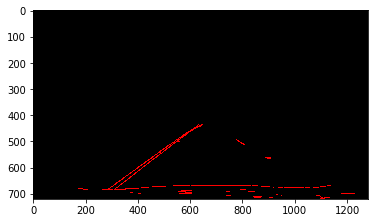

In [57]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [55]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))